In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Import data and train model

In [3]:
from mnist import MNIST

mnist = MNIST('data')

x_train, y_train = mnist.load_training() # 60000 samples
x_test, y_test = mnist.load_testing() # 10000 samples

# Convert to ndarrays and enforce type
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

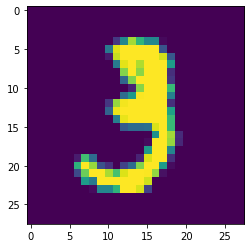

In [4]:
plt.imshow(x_train[10].reshape(28, 28));

In [5]:
# %timeit -r 10 knn.fit(x_train, y_train)
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import time


def knn_timed_fit(x_train, y_train, n_attempts=1, K=3):
    knn = KNeighborsClassifier(n_neighbors=K, n_jobs=-1, metric='euclidean')
    
    times = []
    for _ in tqdm(range(n_attempts)):
        t0 = time.time()
        knn.fit(x_train, y_train)
        times.append(time.time() - t0)
        
    print('K-NN: n={} fits resulted in a mean fit time of {}s'.format(
        n_attempts, np.mean(np.array(times))))
    
    return knn

In [6]:
knn = knn_timed_fit(x_train, y_train, n_attempts=3)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:27<00:00, 89.24s/it]


K-NN: n=3 fits resulted in a mean fit time of 89.20355304082234s


In [45]:
y_pred = knn.predict(x_test)

#### Evaluate model

#### Show some misclassified numbers  
Part of ex. 1a

Actual number: 4 
Predicted number: 9


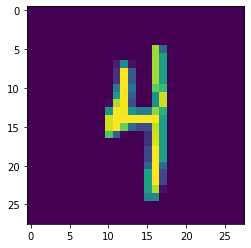

Actual number: 4 
Predicted number: 9


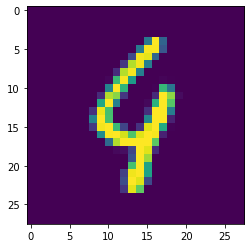

Actual number: 3 
Predicted number: 5


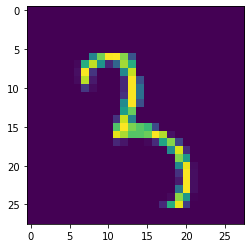

Actual number: 9 
Predicted number: 8


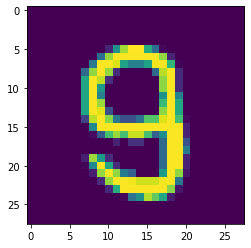

Actual number: 4 
Predicted number: 6


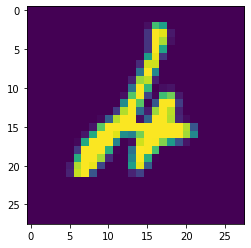

In [8]:
bins = [1 if i == j else 0 for i, j in zip(y_pred, y_test)]
fail_idxs = [i for i in range(len(bins)) if bins[i] == 0]
max_n = 5

# 1b
for n, idx in enumerate(fail_idxs):
    if n >= max_n:
        break
    print('Actual number:', y_test[idx], '\nPredicted number:', y_pred[idx])
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.show()

#### Confusion matrix and error rates  
Part of ex. 1a

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



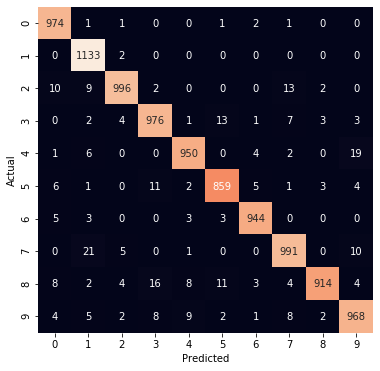

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb


def evaluation_report(y_true, y_pred):
    """Find the confusion matrix and the error rate for the NN classifier.
    
    Params:
        y_true: np.ndarray
            True target values
        y_pred: np.ndarray
            Predicted target values
    """
    print(classification_report(y_true, y_pred))

    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    plt.figure(figsize=(6, 6))
    sb.heatmap(df_cm, fmt='d', annot=True, cbar=False);


evaluation_report(y_test, y_pred)

### Exercise 2

In [16]:
def get_class_members(y, x):
    """Place all x members of a y class into a dict.
    
    Params:
        x: np.ndarray
            Feature vectors
        y: np.ndarray
            True target values
    Returns:
        class_members: dict
            Format: {1: [np.ndarray, ...], 2:...}
    """
    class_members = {}
    # Initialize class member vector lists
    for class_ in np.unique(np.array(y_test)): # aka set
        class_members[class_] = []
    # Put vectors in corresponding baskets
    for class_, vector in zip(y, x):
        class_members[class_].append(vector)
    return class_members


class_members = get_class_members(y_train, x_train)

In [17]:
from sklearn.cluster import KMeans


def get_template_class_members(class_members, n_templates=64, show_progress=True):
    """Condense x, y set into n_templates classes using class-wise K-means clustering.
    K-means cluster centroids act as template vectors.
    
    Params:
        class_members: dict
            Format: {1: [np.ndarray, ...], 2:...}
        n_templates: int
            Amount of template images per MNIST integer
        show_progress: bool
            Show progress bar toggle
    Returns:
        template_class_members: dict
            Condensed version of class_members parameter.
            Format: {1: [np.ndarray, ...], 2:...}
    """
    kmeans = KMeans(n_clusters=n_templates, verbose=1, n_jobs=-1)
    # Wrap iterator in tqdm progress indicator
    if show_progress:
        class_items = tqdm(class_members.items())
    else:
        class_items = class_members.items()
    # Cluster classes into fewer template classes
    template_class_members = {}
    for class_, members in class_items:
        class_kmeans = kmeans.fit(members)
        template_vectors = class_kmeans.cluster_centers_
        template_class_members[class_] = template_vectors
    return template_class_members


template_class_members = get_template_class_members(class_members)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [22:10<00:00, 133.02s/it]


#### Train the KNN with the template classes  
Notice greatly reduced training time.

In [47]:
# Flatten training data to fit x, y format
template_x, template_y = [], []
for class_, template_vectors in template_class_members.items():
    template_y.extend([class_]*len(template_vectors))
    template_x.extend(template_vectors)

small_knn = knn_timed_fit(template_x, template_y, n_attempts=10, K=3)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.52it/s]


K-NN: n=10 fits resulted in a mean fit time of 0.17876069545745848s


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.94      1.00      0.96      1135
           2       0.95      0.94      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.93      0.93       982
           5       0.93      0.95      0.94       892
           6       0.97      0.97      0.97       958
           7       0.96      0.92      0.94      1028
           8       0.96      0.91      0.94       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



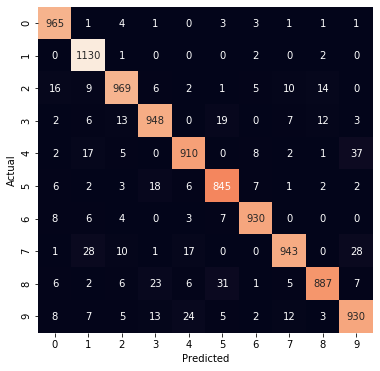

In [48]:
y_pred = small_knn.predict(x_test)
evaluation_report(y_test, y_pred)

#### Training the KNN again, this time with 7 clusters

In [49]:
K7_knn = knn_timed_fit(template_x, template_y, n_attempts=10, K=7)
y_pred = K7_knn.predict(x_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.88it/s]


K-NN: n=10 fits resulted in a mean fit time of 0.14307770729064942s


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.93      0.99      0.96      1135
           2       0.96      0.92      0.94      1032
           3       0.92      0.94      0.93      1010
           4       0.93      0.91      0.92       982
           5       0.92      0.93      0.93       892
           6       0.96      0.97      0.96       958
           7       0.94      0.91      0.93      1028
           8       0.95      0.90      0.92       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



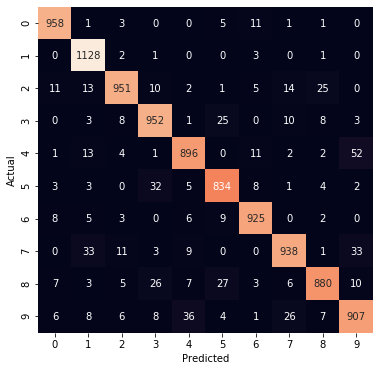

In [50]:
evaluation_report(y_test, y_pred)

#### Measure model prediction speeds  
The template models predict appx. 60 times faster. Note that train speeds also were appx. 500 times faster on template models. Further note that K-means clustering time in the 500x case was ignored, which took appx. 100s. This means that template models were 20% slower to train in total.

In [20]:
def knn_timed_predict(knn, x, n_attempts=10):
    pred_size = len(x)
    times = []
    for _ in range(n_attempts):
        t0 = time.time()
        y_pred = knn.predict(x)
        times.append(time.time() - t0)
    mean = np.mean(np.array(times))
    print(
        """K-NN: n={} predicts resulted in a mean prediction time of {}s
    given a sample of {} items. Pred time per sample: {}s.
        """.format(n_attempts, mean, pred_size, mean/pred_size)
    )
    return y_pred
    
knn_timed_predict(knn, x_test[:1000], n_attempts=1)
knn_timed_predict(small_knn, x_test[:1000])
knn_timed_predict(K7_knn, x_test[:1000])

K-NN: n=1 predicts resulted in a mean prediction time of 40.39792537689209s
    given a sample of 1000 items. Pred time per sample: 0.04039792537689209s.
        
K-NN: n=10 predicts resulted in a mean prediction time of 0.640779685974121s
    given a sample of 1000 items. Pred time per sample: 0.000640779685974121s.
        
K-NN: n=10 predicts resulted in a mean prediction time of 0.6275516033172608s
    given a sample of 1000 items. Pred time per sample: 0.0006275516033172608s.
        
